computing derivatives


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:204: RuntimeWarning: overflow encountered in ubyte_scalars
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:203: RuntimeWarning: overflow encountered in ubyte_scalars


squaring derivatives
apply gaussian filter
apply cornerness function
non-maxima suppression
displaying harris corners



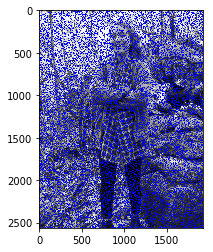

In [8]:
'''
    Q1.1 Harris Corners
'''
%matplotlib inline
import cv2 as cv2
import matplotlib.pyplot as plt
from IPython.display import Image, display
import numpy as np
WINDOW_SIZE = 50

def displayGrey(im,desc=""):
    print desc
    plt.imshow(im)

def resizeImage(image, dbug=False):
    if dbug:
        image = cv2.resize(image, (480, 640))
        # image = cv2.resize(image, (120, 160))
        # image = cv2.resize(image, (1920, 2560))
    else:
        image = cv2.resize(image, (1920, 2560))
    return image


def convolvePointsWith3Kernel(points, kernel):
    '''
    This function will convolve an area of 9 pixels with a 3x3 kernel, and return a value of convolution
    :type kernel: np.array
    :param points: [a,b,]
    :param kernel:
    :return:
    '''

    # FIRST FLIP THE KERNEL???
    kernel = np.fliplr(kernel)

    newValue = 0
    sz = kernel.shape
    for i in range(sz[0]):
        for j in range(sz[1]):
            fctor = points[i][j] * kernel[i][j]
            newValue += fctor
    return int(newValue)


def edgeMaximaSuppression(corn, windowSize):
    """
    This function takes an image, and only returns the local maximums of each pixel.
    Basically removes all of the 'not so hot corners'
    Taken from this algorithm below.
    http://stackoverflow.com/questions/29057159/non-local-maxima-suppression-in-python
    :param corn: Image with bad corners
    :return: Image without all the noise
    """
    dx, dy = windowSize, windowSize
    length, width = corn.shape[0], corn.shape[1]
    for x in range(length - dx + 1):
        for y in range(0, width - dy + 1):
            '''
            The idea is to create a window and move it along the entire image
            Then you can sum all the values inside of the window, apply operations to them...
            In this case, we want to find the local maxima of the window, and then make all the other pixel vals 0
            '''
            wind = corn[x:x + dx, y:y + dy]  # Create the window
            # If the sum of values in the window is 0, then the local max is a zero
            if np.sum(wind) == 0:
                lmax = 0
            else:
                lmax = np.amax(wind)  # Gets the maximum value along the window
            maxPosition = np.argmax(wind)  # The the x,y value that has this maximum value
            wind[:] = 0  # MAke all values in the window 0
            wind.flat[maxPosition] = lmax  # Places the maximum value in the correct place
    return corn


def cornerness(Sx2, Sy2, Sxy):
    '''
    The idea is that at each pixel of the image we define a value based off of the derivatives
    that have already been filtered by the Gaussian kernel

    For every single value. We need to find the HARRIS OPERATOR at that pixels value. This number
    tells us how likely that pixel is to being a corner somehow
    :param filteredImage:
    :return:
    '''
    A = .05
    sz = Sx2.shape
    corn = np.zeros(sz, dtype=np.float32)
    # First iterate through every pixel in the different images
    for i in range(sz[0]):
        for j in range(sz[1]):
            x = Sx2[i][j]
            y = Sy2[i][j]
            xy = Sxy[i][j]

            # Apply harris cornerness function as per slide 46 of Lecture 6, Computer Vision, McGill
            har = x * y - (xy ** 2) - (A * (x + y))
            corn[i][j] = har

    return corn


def gaussian_filter2(ix2, iy2, ixy):
    """
    We need to apply a Gaussian filter to smooth out the original image somewhat
    The old implementation was too slow
    :param ix2: Padded X_squared derivative image
    :param iy2:'' y_ysqured'' ...
    :param ixy:
    :return:
    """
    kernel = [
        [1, 2, 1],
        [2, 4, 2],
        [1, 2, 1]
    ]
    kernel = np.array(kernel, dtype=np.float32)
    kernel / 16
    ix2 = convolutionFunction2(ix2, kernel)
    iy2 = convolutionFunction2(iy2, kernel)
    ixy = convolutionFunction2(ixy, kernel)

    return ix2, iy2, ixy


def convolutionFunction2(image, kernel):
    '''
    This function takes as input an image and then convolves it with the spec. kernel
    :param image: The original black and white image
    :param kernel: A 3x3 kernel
    :return: The filtered image
    '''
    image = np.array(image, dtype=np.float32)

    # Zero pad the image
    image = np.pad(image, 1, "constant")

    # FLIP THE KERNEL?? https://en.wikipedia.org/wiki/Kernel_(image_processing)
    kernel = np.fliplr(kernel)

    # Convert kernel to a 1x9 matrix
    kernel = np.reshape(kernel, (1, 9))

    # Then start convolving
    sz = image.shape
    newImg = np.zeros(sz, dtype=np.float32)
    # print ("Convoluding image with specified kernel" + str(kernel))
    for i in range(1, sz[0] - 1):
        for j in range(1, sz[1] - 1):
            window = image[i - 1:i + 2, j - 1:j + 2]  # First get the points that make up our window
            # Then convolve the kernel with these points
            m1 = np.reshape(window, (1, 9))
            newImg[i][j] = np.inner(kernel, m1)

    return newImg


def squareDervivatives(dx, dy):
    '''
    This function will square all of the derivatives that we are interested in and
    generate the x squared, y squared and xy squared values nescessary for finding the harris corners
    :param dx:
    :param dy:
    :return:
    '''
    shp = dx.shape
    ix2, iy2, ixy = np.zeros(shp), np.zeros(shp), np.zeros(shp)
    length, width = shp[0], shp[1]
    for i in range(length):
        for j in zip(range(width)):
            # Get the value at the x,y coordinate of each image
            x = dx[i][j]
            y = dy[i][j]

            ix2[i][j] = x ** 2
            iy2[i][j] = y ** 2
            ixy[i][j] = x * y
    return ix2, iy2, ixy


def computeImageDerivatives2(im):
    '''
    Seems annoying to manually implement the np.gradient function but here goes
    Gradient function taken from the site below
    http://math.stackexchange.com/questions/1394455/how-do-i-compute-the-gradient-vector-of-pixels-in-an-image
    :param im: Unpadded raw image
    :return:
    '''

    # Create the derivative image copies
    D_X, D_Y = np.zeros(im.shape), np.zeros(im.shape)
    shp = im.shape

    # Zero pad the image
    im = np.pad(im, 1, "constant")

    # Then starting at 1,1 the (original) beginning of the image, start computing the derivatives
    dx, dy = 0, 0
    for i in range(1, shp[0]):
        for j in range(1, shp[1]):
            # Then compute the image derivatives
            try:
                D_X[i - 1][j - 1] = .5 * (im[i + 1][j] - im[i - 1][j])
                D_Y[i - 1][j - 1] = .5 * (im[i][j + 1] - im[i][j - 1])
            except Exception:
                D_X[i - 1][j - 1] = 0
                D_Y[i - 1][j - 1] = 0
    # testx,texy = np.gradient(im) #So much easier than this :/
    return D_X, D_Y


def displayHarrisCorners(nonMCorn, image):
    '''
    This function takes as input an image and an 'image of corners' which we will color
    and then overlay over the original image
    :param corn: A 2D array, the same size of the image, where the values represent corners
    :param image: A 2D array, that represents a standard greyscale image
    :return:
    '''

    image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    thresh = 200
    sz = image.shape
    l, w = sz[0], sz[1]
    for i in range(l):
        for j in range(w):
            if nonMCorn[i][j] > thresh:
                cv2.circle(image, (j, i), 3, (0, 0, 255), 3)
    return image


def harrisCorners(im):
    # Zero pad the image
    im = np.pad(im, 1, "constant")

    # First compute the image derivatives
    print "computing derivatives"
    dx, dy = computeImageDerivatives2(im)

    # Then square the derivatives
    print "squaring derivatives"
    ix2, iy2, ixy = squareDervivatives(dx, dy)

    # Then apply the gaussian filter
    print "apply gaussian filter"
    Gx2, Gy2, Gxy = gaussian_filter2(ix2, iy2, ixy)

    # Then the cornerness function
    print "apply cornerness function"
    corn = cornerness(Gx2, Gy2, Gxy)

    # Then non-maxima suppresion
    print "non-maxima suppression"
    nonMaxCorn = edgeMaximaSuppression(corn, WINDOW_SIZE)  # Perform the canny edge detector

    # Then display the harris corners
    print "displaying harris corners"
    finalImage = displayHarrisCorners(nonMaxCorn, im)

    return finalImage

def harrisCorns():
    # First thing to do is import the image
    image = cv2.imread("./images/Rebecca1.jpg", 0)
    np.array(image, dtype=np.uint8)

    # then resize the image
    image = resizeImage(image)

    # Then apply the harris corners algorithm to the image
    return harrisCorners(image)
    

# image = cv2.imread("./images/Rebecca1.jpg",0)
# displayGrey(image,"GREYSCALE")
imCorns = harrisCorns()
displayGrey(imCorns)

Computing the sift feature descriptors...
Use the BF matcher to find the good matches between images
Pick the top 50 matches
Draw the matches


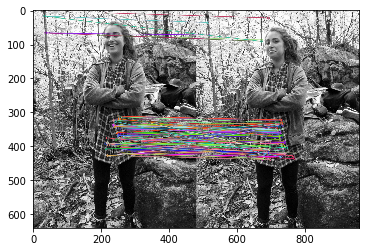

In [10]:
'''
    Q1.2 Feature Comparison
'''

import cv2 as cv2
import matplotlib.pyplot as plt
import numpy as np
import warnings

warnings.filterwarnings("ignore")

DEBUG = True


def resizeImage(image, dbug=DEBUG):
    if dbug:
        image = cv2.resize(image, (480, 640))
        # image = cv2.resize(image, (120, 160))
        # image = cv2.resize(image, (1920, 2560))
    else:
        image = cv2.resize(image, (1920, 2560))
    return image


def match(im1, im2):
    """
    Will apply the sift feature matching algorithm to 2 images
    The majority of the algorithm / code has been taken from this source below
    CITATION: http://docs.opencv.org/trunk/dc/dc3/tutorial_py_matcher.html
    :param im1:
    :param im2:
    :return:
    """
    '''
        First thing to do is to get the sift features
    '''
    print ("Computing the sift feature descriptors...")
    sift_1, sift_2 = cv2.xfeatures2d.SIFT_create(), cv2.xfeatures2d.SIFT_create()
    kp1, des1 = sift_1.detectAndCompute(im1, None)
    kp2, des2 = sift_2.detectAndCompute(im2, None)

    print ("Use the BF matcher to find the good matches between images")
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    print ("Pick the top 50 matches")
    bestMatches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            bestMatches.append((m, n))

    # Sort the matches by distance
    bMatches = sorted(bestMatches, key=lambda x: x[1].distance, reverse=False)[:50]

    print "Draw the matches"
    newIm = cv2.drawMatchesKnn(im1, kp1, im2, kp2, bMatches, None, flags=2)
    return newIm


def featureMatch():
    # First thing to do is import the image
    im1 = cv2.imread("./images/Rebecca1.jpg", 0)
    np.array(im1, dtype=np.uint8)

    im2 = cv2.imread("./images/Rebecca2.jpg", 0)
    np.array(im2, dtype=np.uint8)

    # then resize the images
    im1 = resizeImage(im1)
    im2 = resizeImage(im2)

    # Then do the feature matching
    newIm = match(im1, im2)
    Image(newIm)
    # il.log(newIm, "matches")
    plt.imshow(newIm)

if __name__ == '__main__':
    featureMatch()

Processing celebrity images:   0%|          | 0/14 [00:00<?, ?it/s]

Importing the celebrity image
['000016.jpg', '000029.jpg', '000031.jpg', '000038.jpg', '000048.jpg', '000050.jpg', '000058.jpg', '000080.jpg', '000101.jpg', '000103.jpg', '000111.jpg', '000124.jpg', '000126.jpg', '000133.jpg']


Finding features:   0%|          | 0/49 [00:00<?, ?it/s]

Get my descriptor


Comparing Celebs...: 100%|██████████| 14/14 [00:00<00:00, 10870.10it/s]


Getting celebrity descriptors
Celebrity
Me


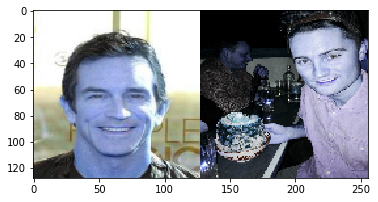

In [23]:
'''
    Q2 Face Matching
'''
%matplotlib inline
import cv2 as cv2
import matplotlib.pyplot as plt
from IPython.display import Image, display
import numpy as np
import warnings
import os
from scipy.spatial.distance import cdist



warnings.filterwarnings("ignore")
from tqdm import tqdm as tqdm

DEBUG = True
path = "./img_align_celeba/"
myImagePath = "./images/Evan.jpg"

def importCelebImages():
    """
    This function will import all the images, and compute their descriptors
    :return: an array of image descriptors
    """

    if DEBUG:
        images = os.listdir(path)[1:15]
    else:
        images = os.listdir(path)[1:2000]
    print images
    images_WithFeatures = []
    for index,imageName in tqdm(zip(range(len(images)),images),desc="Processing celebrity images"):
        im = cv2.resize(cv2.imread(path+"/"+imageName,0),(128,128))
        features = [computeLBPDescriptor(i) for i in breakImageApart(im)]
        images_WithFeatures.append((index,features))
    return images_WithFeatures


def resizeImage(image, dbug=DEBUG):
    if dbug:
        image = cv2.resize(image, (128, 128))
        # image = cv2.resize(image, (120, 160))
        # image = cv2.resize(image, (1920, 2560))
    else:
        image = cv2.resize(image, (128, 128))
    return image

def computeLBPDescriptor(im):
    # Zero pad the image
    im = np.pad(im, 1, "constant")

    sz = im.shape
    histogram = np.zeros((256, 1), dtype=np.uint8)

    '''
    First thing to do is to get the binary label for each pixel value,
    and while doing that, build our histogram
    '''
    for i in range(1, sz[0] - 1):
        for j in range(1, sz[1] - 1):
            window = im[i - 1:i + 2, j - 1:j + 2]
            thresh = im[i][j]
            # Gets you the indexes that fall below/above the values
            zeroIndexes = window < thresh
            oneIndexes = window >= thresh
            wincpy = window.copy()
            wincpy[zeroIndexes] = 0
            wincpy[oneIndexes] = 1

            # Then get the unique binary value
            binary = wincpy.flatten()
            binary = np.delete(binary, 4)  # The 4th element is the middle index
            bin_val = binary.dot(2 ** np.arange(binary.size)[::-1])
            histogram[bin_val] += 1

    return histogram

def breakImageApart(im):
    """
    this function will break up the original image apart into roughly equal 7x7 sections
    :param im:
    :return:
    """
    segments = []
    # First get all of the vertical slices, should be around 18 pixels tall each
    horizontalSlices = np.array_split(im, 7)

    # Then for each vertical slice, horizontally split the arrays into segments...
    for i in horizontalSlices:
        verticalSlices = np.array_split(i, 7, axis=1)
        for slice in verticalSlices:
            segments.append(slice)

    return segments

def compareFeatures(myPictureSummary,celebListSummary):
    comparisons = []
    myFeatures = np.array(myPictureSummary).flatten()
    for index,celeb in tqdm(zip(range(len(celebListSummary)),celebListSummary),desc="Comparing Celebs..."):
        sum = 0
        celebFeatures = np.array(celeb[1]).flatten()
        sum = ((myFeatures-celebFeatures)**2).sum()
        comparisons.append((index,sum))

    #Then find the closest celeb to me
    closestCeleb = min(comparisons, key=lambda t: t[1])
    return closestCeleb[0]

def faceMatch():
    """
    This function will be a celebrity face matching exercise with my face
    :return: The celebrity I look the most like
    """

    # First thing is to import all the images, resize them, and compute their descriptors
    print ("Importing the celebrity image")
    imagesWithFeatures = importCelebImages()

    # Then get our image, resize it and compute it's descriptor
    print ("Get my descriptor")
    me_im = cv2.imread(myImagePath, 0)
    me_im = resizeImage(me_im)
    imSegments = breakImageApart(me_im)
    me_features = [computeLBPDescriptor(i) for i in tqdm(imSegments, desc="Finding features")]

    # Then compare our fDescriptor with all the others! Will return index of image we want
    print ("Getting celebrity descriptors")
    celebIndex = compareFeatures(me_features, imagesWithFeatures)
    images = os.listdir(path)
    celeb = images[celebIndex]
    celebrityImage = resizeImage(cv2.imread(path+"/"+celeb))
    me_im = resizeImage(cv2.imread(myImagePath))
    Image(me_im)
    Image(celebrityImage)
    print ("Celebrity")
    plt.imshow(celebrityImage)
    print ("Me")
    plt.imshow(me_im)
    
    '''
        Because Ipython is the worst and I have to combine these?
    '''
    h1, w1 = celebrityImage.shape[:2]
    h2, w2 = me_im.shape[:2]

    #create empty matrix
    vis = np.zeros((max(h1, h2), w1+w2,3), np.uint8)

    #combine 2 images
    vis[:h1, :w1,:3] = celebrityImage
    vis[:h2, w1:w1+w2,:3] = me_im
    
    plt.imshow(vis)
    


faceMatch()